### Classifier with TF-IDF vectors
Dataset size:
* Train: 50,000
* Test: 5,000

TF-IDF vectors:
* max_features: 1,000
* min_df: 10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import cross_validate
from sklearn import svm
import pickle
import sys
import keras
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [2]:
train_set = pd.read_csv("dataset_train_pp.csv")
test_set = pd.read_csv("dataset_test_pp.csv")

In [3]:
print(len(train_set))
print(len(test_set))

50000
5000


In [4]:
train_x=train_set["Description"]
test_x=test_set["Description"]

train_y=train_set["Class Index"]
test_y=test_set["Class Index"]

In [5]:
%%time
test_x_vectors = np.load("tfidf_test_x_1000.npy")

CPU times: user 0 ns, sys: 60.5 ms, total: 60.5 ms
Wall time: 799 ms


In [6]:
%%time
train_x_vectors = np.load("tfidf_train_x_1000.npy")

CPU times: user 35.3 ms, sys: 486 ms, total: 522 ms
Wall time: 6.62 s


In [7]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion_matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], 
                horizontalalignment='center', 
                color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Naive Bays

In [8]:
naive_bays = MultinomialNB()

In [9]:
%%time
naive_bays.fit(train_x_vectors, train_y)

CPU times: user 558 ms, sys: 31.3 ms, total: 589 ms
Wall time: 289 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
p = pickle.dumps(naive_bays)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

80.749


In [11]:
%%time
nb_pred_x = naive_bays.predict(test_x_vectors)

CPU times: user 48.1 ms, sys: 23.1 ms, total: 71.3 ms
Wall time: 31 ms


In [12]:
accuracy_score(test_y,nb_pred_x)

0.814

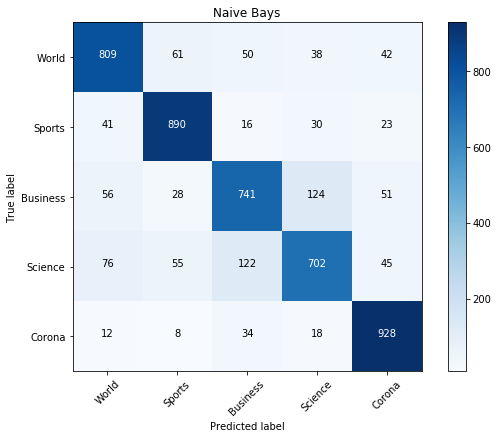

In [13]:
nb_cm = confusion_matrix(test_y, nb_pred_x)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nb_cm, cmPlotLabels, title='Naive Bays')

### SVM

In [13]:
svm_model = svm.SVC(kernel='poly', degree=2, gamma='scale')

In [15]:
%%time
svm_model.fit(train_x_vectors, train_y)
# svm_model.fit(test_x_vectors, test_y) for speed test

CPU times: user 3h 8min 22s, sys: 25.5 s, total: 3h 8min 48s
Wall time: 3h 9min 24s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='scale', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
p = pickle.dumps(svm_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

235311.743


In [25]:
%%time
svm_pred_x = svm_model.predict(test_x_vectors)

CPU times: user 6min 42s, sys: 2.57 s, total: 6min 45s
Wall time: 6min 48s


In [26]:
accuracy_score(test_y,svm_pred_x)

0.8576

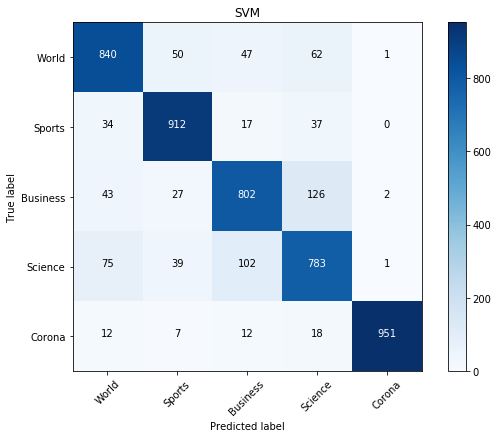

In [27]:
svm_cm = confusion_matrix(test_y, svm_pred_x)
plot_confusion_matrix(svm_cm, cmPlotLabels, title='SVM')

### NN

#### Prepare labels for keras

In [8]:
enc = OneHotEncoder(handle_unknown='ignore')

In [9]:
test_y_array = test_y.to_numpy().reshape(-1,1)
train_y_array = train_y.to_numpy().reshape(-1,1)

In [10]:
enc.fit(test_y_array)
test_y_1hot = enc.transform(test_y_array).toarray()

In [11]:
enc.fit(train_y_array)
train_y_1hot = enc.transform(train_y_array).toarray()

#### keras model

In [13]:
nn_model = None
nn_model = keras.models.Sequential()
nn_model.add(keras.layers.Dense(32, input_dim=1000, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(16, activation='relu'))
nn_model.add(keras.layers.Dense(5, activation='softmax'))

In [14]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                32032     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 85        
Total params: 32,917
Trainable params: 32,917
Non-trainable params: 0
_________________________________________________________________


In [16]:
nn_model.compile(keras.optimizers.Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
%%time
nn_model.fit(train_x_vectors, train_y_1hot, epochs=30, batch_size=10)

W0615 23:05:42.808520 140013285185280 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0615 23:05:42.953498 140013285185280 deprecation_wrapper.py:119] From /home/amirhossein/.local/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
50000/50000 [==============================] - 21s 421us/step - loss: 0.5828 - acc: 0.7869
Epoch 2/30
50000/50000 [==============================] - 18s 363us/step - loss: 0.4267 - acc: 0.8499
Epoch 3/30
50000/50000 [==============================] - 17s 345us/step - loss: 0.3963 - acc: 0.8587
Epoch 4/30
50000/50000 [==============================] - 17s 347us/step - loss: 0.3788 - acc: 0.8645
Epoch 5/30
50000/50000 [==============================] - 17s 346us/step - loss: 0.3620 - acc: 0.8713
Epoch 6/30
50000/50000 [==============================] - 17s 349us/step - loss: 0.3465 - acc: 0.8767
Epoch 7/30
50000/50000 [==============================] - 18s 350us/step - loss: 0.3305 - acc: 0.8812
Epoch 8/30
50000/50000 [==============================] - 18s 353us/step - loss: 0.3139 - acc: 0.8879
Epoch 9/30
50000/50000 [==============================] - 18s 352us/step - loss: 0.2974 - acc: 0.8948
Epoch 10/30
50000/50000 [==============================] - 18s 355us/step - loss: 

In [18]:
p = pickle.dumps(nn_model)
memoryKB = sys.getsizeof(p)/1000
print(memoryKB)

406.412


In [19]:
nn_model.evaluate(test_x_vectors, test_y_1hot, batch_size=10)

5000/5000 [==============================] - 1s 165us/step


[1.2036714870522074, 0.8023999977409839]

In [20]:
%%time
predictions = nn_model.predict(test_x_vectors)

CPU times: user 311 ms, sys: 13 ms, total: 324 ms
Wall time: 273 ms


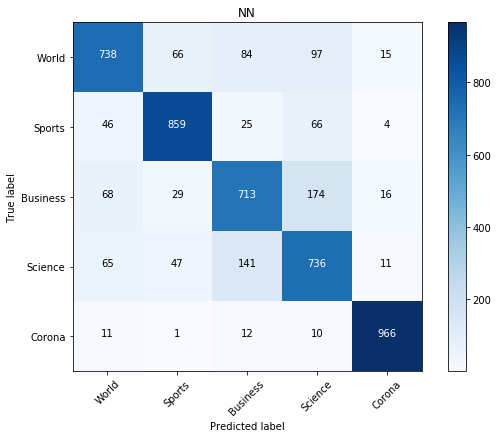

In [21]:
nn_cm = confusion_matrix(test_y, predictions.argmax(axis=1)+1)
cmPlotLabels = ['World', 'Sports', 'Business', 'Science', 'Corona']
plot_confusion_matrix(nn_cm, cmPlotLabels, title='NN')

In [22]:
nn_model.save("nn_tfidf_1000.h5")